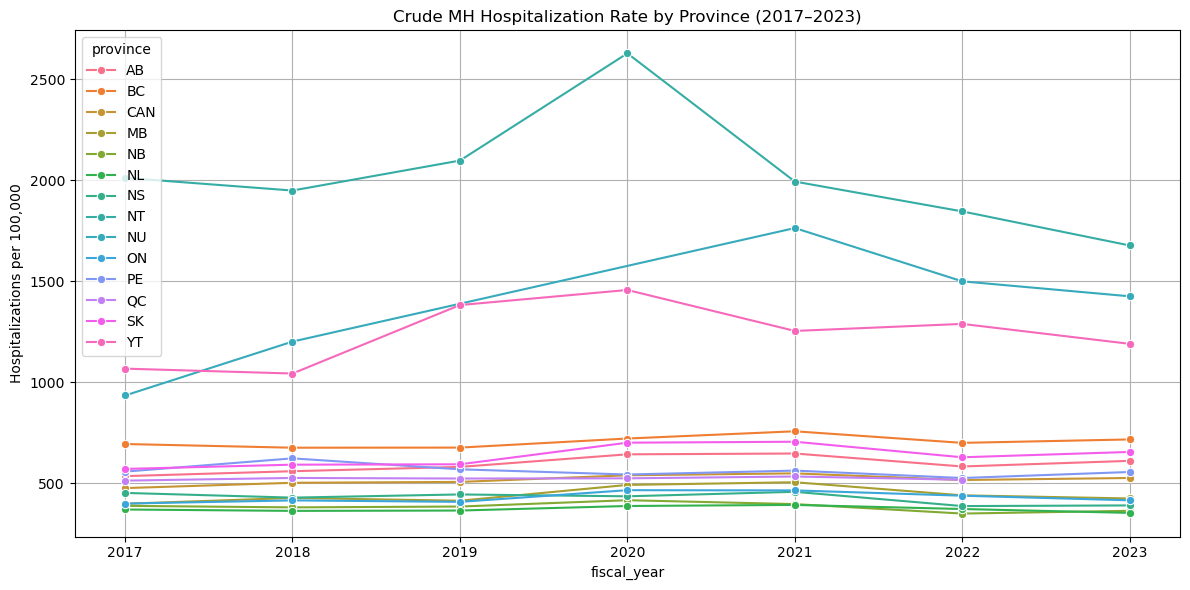

Merged dataset shape: (54, 8)


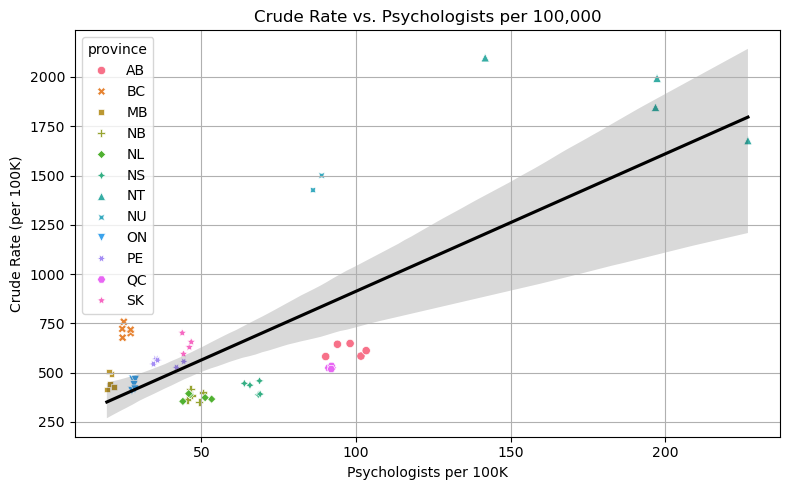

                            OLS Regression Results                            
Dep. Variable:             crude_rate   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     68.34
Date:                Mon, 21 Jul 2025   Prob (F-statistic):           4.83e-11
Time:                        00:31:51   Log-Likelihood:                -379.44
No. Observations:                  54   AIC:                             762.9
Df Residuals:                      52   BIC:                             766.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    215

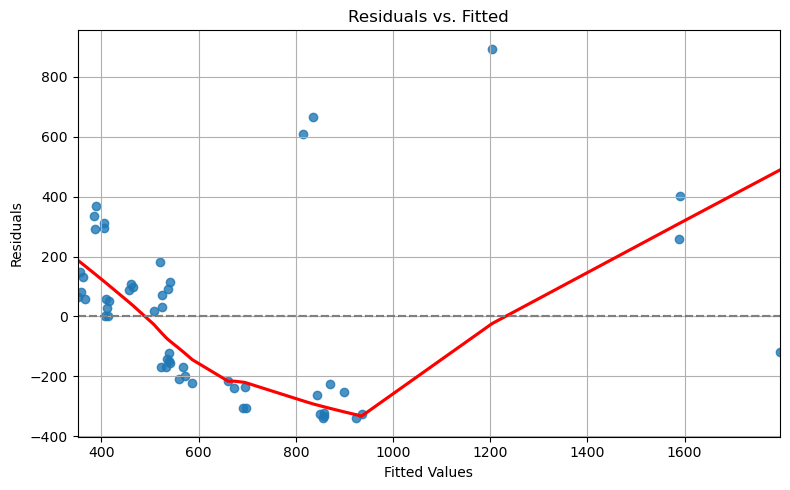

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence


hospital_df = pd.read_csv("C://Users//shoaib//Desktop//Mental_health_ed_project//Cleaned_dataset//cihi_hospital_stays_prov_year_2017-2023.csv.csv")
workforce_df = pd.read_csv("C://Users//shoaib//Desktop//Mental_health_ed_project//Cleaned_dataset//cihi_workforce_prov_year_2019-2023.csv.csv")


# Drop rows with suppressed crude rates
hospital_df_clean = hospital_df[~hospital_df['crude_rate'].isna()].copy()

# Confirm crude rate is correct
hospital_df_clean['calc_crude_rate'] = (hospital_df_clean['count'] / hospital_df_clean['population']) * 100000
assert all(abs(hospital_df_clean['crude_rate'] - hospital_df_clean['calc_crude_rate']) < 0.01), "Mismatch in crude rate calculation"


# Plot Crude Rates by Province Over Time
 
plt.figure(figsize=(12, 6))
sns.lineplot(data=hospital_df_clean, x='fiscal_year', y='crude_rate', hue='province', marker='o')
plt.title('Crude MH Hospitalization Rate by Province (2017–2023)')
plt.ylabel('Hospitalizations per 100,000')
plt.grid(True)
plt.tight_layout()
plt.show()

psych_df = workforce_df[
    (workforce_df['profession'].str.lower() == 'psychologists') &
    (workforce_df['per_100k'].notna())
].copy()

# Rename for join
psych_df.rename(columns={'year': 'fiscal_year', 'per_100k': 'psychologists_per_100k'}, inplace=True)


# Merge: Hospitalization + Psychologists

merged_df = pd.merge(
    hospital_df_clean,
    psych_df[['province', 'fiscal_year', 'psychologists_per_100k']],
    on=['province', 'fiscal_year'],
    how='inner'
)

# Drop provinces or years not present in both
print("Merged dataset shape:", merged_df.shape)

# ------------------------------
# Scatter Plot + Regression Line
# ------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=merged_df,
    x='psychologists_per_100k',
    y='crude_rate',
    hue='province',
    style='province'
)
sns.regplot(
    data=merged_df,
    x='psychologists_per_100k',
    y='crude_rate',
    scatter=False,
    ci=95,
    color='black'
)
plt.title('Crude Rate vs. Psychologists per 100,000')
plt.xlabel('Psychologists per 100K')
plt.ylabel('Crude Rate (per 100K)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# Regression Analysis
# ------------------------------
X = sm.add_constant(merged_df['psychologists_per_100k'])
y = merged_df['crude_rate']
model = sm.OLS(y, X).fit()
print(model.summary())

# ------------------------------
# Influence Diagnostics
# ------------------------------
influence = OLSInfluence(model)
merged_df['cooks_d'] = influence.cooks_distance[0]
merged_df['high_influence'] = merged_df['cooks_d'] > (4 / len(merged_df))

print("\nHigh Influence Points (Cook's D > 4/n):")
print(merged_df[merged_df['high_influence']][['province', 'fiscal_year', 'crude_rate', 'psychologists_per_100k', 'cooks_d']])

# ------------------------------
# Residual Plot
# ------------------------------
plt.figure(figsize=(8, 5))
residuals = model.resid
fitted = model.fittedvalues
sns.residplot(x=fitted, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
from scipy.stats import pearsonr, spearmanr

# Drop NA just in case
df_corr = merged_df[['crude_rate', 'psychologists_per_100k']].dropna()

# Pearson correlation
pearson_r, p_pearson = pearsonr(df_corr['crude_rate'], df_corr['psychologists_per_100k'])

# Spearman correlation
spearman_r, p_spearman = spearmanr(df_corr['crude_rate'], df_corr['psychologists_per_100k'])

print(f"📈 Pearson correlation: r = {pearson_r:.2f}, p = {p_pearson:.4f}")
print(f"📊 Spearman correlation: r = {spearman_r:.2f}, p = {p_spearman:.4f}")


📈 Pearson correlation: r = 0.75, p = 0.0000
📊 Spearman correlation: r = 0.22, p = 0.1095


📈 Pearson correlation (w/o NT/NU): r = 0.06, p = 0.7014
📊 Spearman correlation (w/o NT/NU): r = -0.08, p = 0.5985


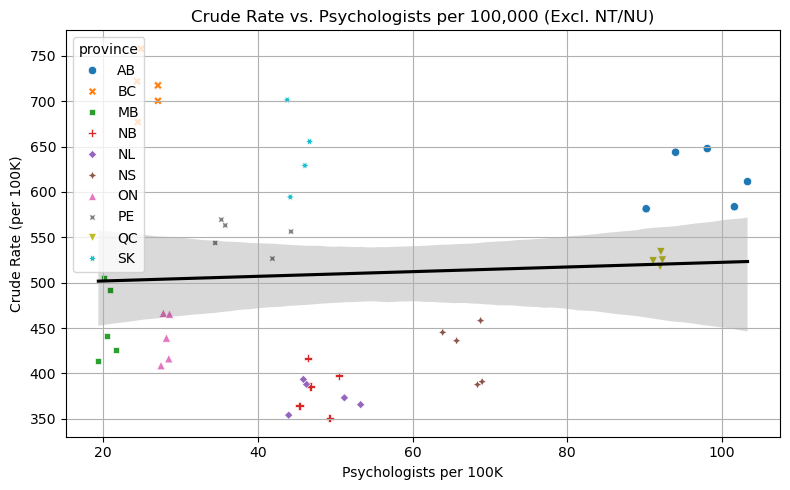

In [17]:
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------
# Filter out NT and NU (territories)
# -----------------------------------------
df_filtered = merged_df[~merged_df['province'].isin(['NT', 'NU'])].copy()

# -----------------------------------------
# Re-run correlation without NT and NU
# -----------------------------------------
df_corr_filt = df_filtered[['crude_rate', 'psychologists_per_100k']].dropna()

# Pearson
pearson_r_filt, p_pearson_filt = pearsonr(df_corr_filt['crude_rate'], df_corr_filt['psychologists_per_100k'])

# Spearman
spearman_r_filt, p_spearman_filt = spearmanr(df_corr_filt['crude_rate'], df_corr_filt['psychologists_per_100k'])

print(f"📈 Pearson correlation (w/o NT/NU): r = {pearson_r_filt:.2f}, p = {p_pearson_filt:.4f}")
print(f"📊 Spearman correlation (w/o NT/NU): r = {spearman_r_filt:.2f}, p = {p_spearman_filt:.4f}")

# -----------------------------------------
# Replot scatter without NT and NU
# -----------------------------------------
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_filtered,
    x='psychologists_per_100k',
    y='crude_rate',
    hue='province',
    style='province'
)
sns.regplot(
    data=df_filtered,
    x='psychologists_per_100k',
    y='crude_rate',
    scatter=False,
    ci=95,
    color='black'
)
plt.title('Crude Rate vs. Psychologists per 100,000 (Excl. NT/NU)')
plt.xlabel('Psychologists per 100K')
plt.ylabel('Crude Rate (per 100K)')
plt.grid(True)
plt.tight_layout()
plt.show()


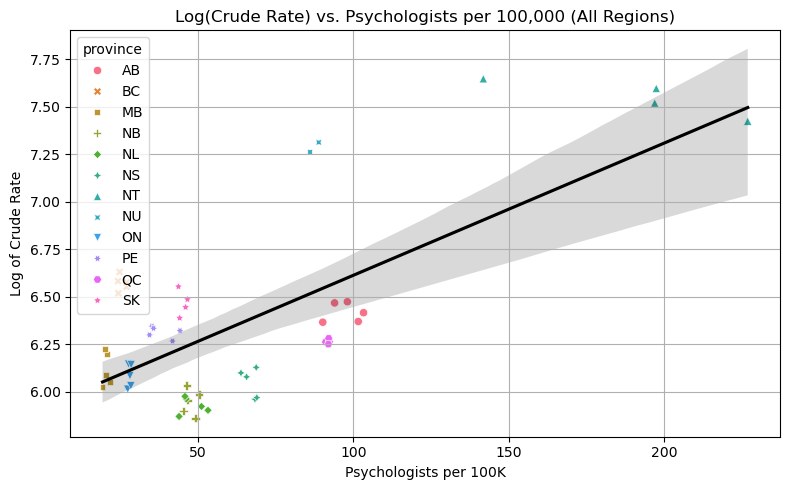

📈 Pearson correlation (log): r = 0.70, p = 0.0000
📊 Spearman correlation (log): r = 0.22, p = 0.1095


In [19]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

# ---------------------------------------
# Log-transform crude_rate (after dropna)
# ---------------------------------------
df_log = merged_df.dropna(subset=['crude_rate', 'psychologists_per_100k']).copy()
df_log['log_crude_rate'] = np.log(df_log['crude_rate'])

# ---------------------------------------
# Scatter plot: log(Crude Rate) vs Psychologists
# ---------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_log,
    x='psychologists_per_100k',
    y='log_crude_rate',
    hue='province',
    style='province'
)
sns.regplot(
    data=df_log,
    x='psychologists_per_100k',
    y='log_crude_rate',
    scatter=False,
    ci=95,
    color='black'
)
plt.title('Log(Crude Rate) vs. Psychologists per 100,000 (All Regions)')
plt.xlabel('Psychologists per 100K')
plt.ylabel('Log of Crude Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# Correlation: log(Crude Rate) vs Psychologists
# ---------------------------------------
pearson_r_log, p_pearson_log = pearsonr(df_log['log_crude_rate'], df_log['psychologists_per_100k'])
spearman_r_log, p_spearman_log = spearmanr(df_log['log_crude_rate'], df_log['psychologists_per_100k'])

print(f"📈 Pearson correlation (log): r = {pearson_r_log:.2f}, p = {p_pearson_log:.4f}")
print(f"📊 Spearman correlation (log): r = {spearman_r_log:.2f}, p = {p_spearman_log:.4f}")
